# *(Yang, 2020)*: Dynamical system analysis for RNN

Implementation of the paper:

- Yang G R, Wang X J. Artificial neural networks for neuroscientists: A primer[J]. Neuron, 2020, 107(6): 1048-1070.

The original implementation is based on PyTorch: https://github.com/gyyang/nn-brain/blob/master/RNN%2BDynamicalSystemAnalysis.ipynb

In [1]:
import brainpy as bp
import brainpy.math as bm
bp.math.set_platform('cpu')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In this tutorial, we will use supervised learning to train a recurrent neural network on a simple perceptual decision making task, and analyze the trained network using dynamical system analysis.

## Defining a cognitive task

In [3]:
# We will import the task from the neurogym library.
# Please install neurogym:
# 
# https://github.com/neurogym/neurogym

import neurogym as ngym

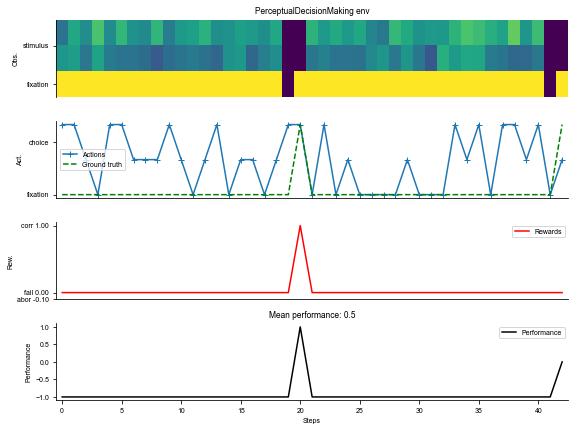

In [4]:
# Environment
task = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 100}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2, fig_kwargs={'figsize': (8, 6)})

In [5]:
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
batch_size = dataset.batch_size

## Define a vanilla continuous-time recurrent network

Here we will define a continuous-time neural network but discretize it in time using the Euler method.

\begin{align}
    \tau \frac{d\mathbf{r}}{dt} = -\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r).
\end{align}

This continuous-time system can then be discretized using the Euler method with a time step of $\Delta t$, 

\begin{align}
    \mathbf{r}(t+\Delta t) = \mathbf{r}(t) + \Delta \mathbf{r} = \mathbf{r}(t) + \frac{\Delta t}{\tau}[-\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r)].
\end{align}

In [6]:
class RNN(bp.dyn.DynamicalSystem):
  def __init__(self, num_input, num_hidden, num_output, num_batch, dt=None, seed=None,
               w_ir=bp.init.KaimingNormal(scale=1.),
               w_rr=bp.init.KaimingNormal(scale=1.),
               w_ro=bp.init.KaimingNormal(scale=1.)):
    super(RNN, self).__init__()

    # parameters
    self.tau = 100
    self.num_batch = num_batch
    self.num_input = num_input
    self.num_hidden = num_hidden
    self.num_output = num_output
    if dt is None:
      self.alpha = 1
    else:
      self.alpha = dt / self.tau
    self.rng = bm.random.RandomState(seed=seed)

    # input weight
    self.w_ir = bm.TrainVar(bp.init.parameter(w_ir, (num_input, num_hidden)))

    # recurrent weight
    bound = 1 / num_hidden ** 0.5
    self.w_rr = bm.TrainVar(bp.init.parameter(w_rr, (num_hidden, num_hidden)))
    self.b_rr = bm.TrainVar(self.rng.uniform(-bound, bound, num_hidden))

    # readout weight
    self.w_ro = bm.TrainVar(bp.init.parameter(w_ro, (num_hidden, num_output)))
    self.b_ro = bm.TrainVar(self.rng.uniform(-bound, bound, num_output))

    # variables
    self.h = bm.Variable(bm.zeros((num_batch, num_hidden)))
    self.o = bm.Variable(bm.zeros((num_batch, num_output)))

  def cell(self, x, h):
    ins = x @ self.w_ir + h @ self.w_rr + self.b_rr
    state = h * (1 - self.alpha) + ins * self.alpha
    return bm.relu(state)

  def readout(self, h):
    return h @ self.w_ro + self.b_ro

  def update(self, x):
    self.h.value = self.cell(x, self.h)
    self.o.value = self.readout(self.h)
    return self.h.value, self.o.value

  def predict(self, xs):
    self.h[:] = 0.
    return bm.for_loop(self.update, xs)

  def loss(self, xs, ys):
    hs, os = self.predict(xs)
    os = os.reshape((-1, os.shape[-1]))
    loss = bp.losses.cross_entropy_loss(os, ys.flatten())
    return loss, os

## Train the recurrent network on the decision-making task

In [7]:
# Instantiate the network and print information
hidden_size = 64
net = RNN(num_input=input_size,
          num_hidden=hidden_size,
          num_output=output_size,
          num_batch=batch_size,
          dt=env.dt)

In [8]:
# prediction method
predict = bm.jit(net.predict, dyn_vars=net.vars())

# Adam optimizer
opt = bp.optim.Adam(lr=0.001, train_vars=net.train_vars().unique())

# gradient function
grad_f = bm.grad(net.loss,
                 grad_vars=net.train_vars().unique(),
                 return_value=True,
                 has_aux=True)

# training function
@bm.jit
@bm.to_object(child_objs=(net, opt))
def train(xs, ys):
  grads, loss, os = grad_f(xs, ys)
  opt.update(grads)
  return loss, os

In [9]:
running_acc = 0
running_loss = 0
for i in range(1500):
  inputs, labels_np = dataset()
  inputs = bm.asarray(inputs)
  labels = bm.asarray(labels_np)
  loss, outputs = train(inputs, labels)
  running_loss += loss
  # Compute performance
  output_np = np.argmax(bm.as_numpy(outputs), axis=-1).flatten()
  labels_np = labels_np.flatten()
  ind = labels_np > 0  # Only analyze time points when target is not fixation
  running_acc += np.mean(labels_np[ind] == output_np[ind])
  if i % 100 == 99:
    running_loss /= 100
    running_acc /= 100
    print('Step {}, Loss {:0.4f}, Acc {:0.3f}'.format(i + 1, running_loss, running_acc))
    running_loss = 0
    running_acc = 0

Step 100, Loss 0.1840, Acc 0.132
Step 200, Loss 0.0422, Acc 0.831
Step 300, Loss 0.0208, Acc 0.870
Step 400, Loss 0.0167, Acc 0.864
Step 500, Loss 0.0144, Acc 0.870
Step 600, Loss 0.0137, Acc 0.870
Step 700, Loss 0.0131, Acc 0.875
Step 800, Loss 0.0130, Acc 0.872
Step 900, Loss 0.0119, Acc 0.883
Step 1000, Loss 0.0124, Acc 0.879
Step 1100, Loss 0.0121, Acc 0.879
Step 1200, Loss 0.0113, Acc 0.891
Step 1300, Loss 0.0115, Acc 0.881
Step 1400, Loss 0.0123, Acc 0.872
Step 1500, Loss 0.0109, Acc 0.890


## Visualize neural activity for in sample trials

We will run the network for 100 sample trials, then visual the neural activity trajectories in a PCA space.

In [10]:
env.reset(no_step=True)
perf = 0
num_trial = 100
activity_dict = {}
trial_infos = {}
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = bm.asarray(ob[:, np.newaxis, :])
    rnn_activity, action_pred = predict(inputs)
    rnn_activity = bm.as_numpy(rnn_activity)[:, 0, :]
    activity_dict[i] = rnn_activity
    trial_infos[i] = env.trial
    
# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)

# Print trial informations
for i in range(5):
    print('Trial ', i, trial_infos[i])

Shape of the neural activity: (Time points, Neurons):  (2200, 64)
Trial  0 {'ground_truth': 0, 'coh': 12.8}
Trial  1 {'ground_truth': 0, 'coh': 0.0}
Trial  2 {'ground_truth': 0, 'coh': 12.8}
Trial  3 {'ground_truth': 0, 'coh': 0.0}
Trial  4 {'ground_truth': 0, 'coh': 0.0}


In [11]:
pca = PCA(n_components=2)
pca.fit(activity)

PCA(n_components=2)

Transform individual trials and Visualize in PC space based on ground-truth color. We see that the neural activity is organized by stimulus ground-truth in PC1

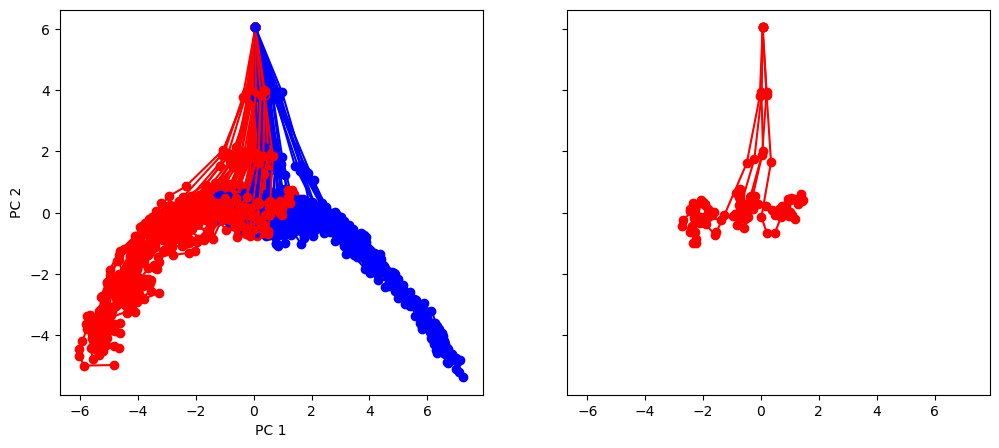

In [12]:
plt.rcdefaults()
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 5))
for i in range(num_trial):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'
    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    if i < 5:
        _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)

ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
plt.show()

## Search for approximate fixed points

Here we search for approximate fixed points and visualize them in the same PC space. In a generic dynamical system,
\begin{align}
    \frac{d\mathbf{x}}{dt} = F(\mathbf{x}),
\end{align}
We can search for fixed points by doing the optimization
\begin{align}
    \mathrm{argmin}_{\mathbf{x}} |F(\mathbf{x})|^2.
\end{align}

In [13]:
f_cell = lambda h: net.cell(bm.asarray([1, 0.5, 0.5]), h)

In [14]:
fp_candidates = bm.vstack([activity_dict[i] for i in range(num_trial)])
fp_candidates.shape

(2200, 64)

In [15]:
finder = bp.analysis.SlowPointFinder(f_cell=f_cell, f_type='discrete')
finder.find_fps_with_gd_method(
  candidates=fp_candidates,
  tolerance=1e-5, num_batch=200,
    optimizer=bp.optim.Adam(lr=bp.optim.ExponentialDecay(0.01, 1, 0.9999)),
)
finder.filter_loss(tolerance=1e-5)
finder.keep_unique(tolerance=0.03)
finder.exclude_outliers(0.1)
fixed_points = finder.fixed_points

Optimizing with Adam(lr=ExponentialDecay(0.01, decay_steps=1, decay_rate=0.9999), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-200 in 0.22 sec, Training loss 0.0023097016
    Batches 201-400 in 0.21 sec, Training loss 0.0005514451
    Batches 401-600 in 0.23 sec, Training loss 0.0002439589
    Batches 601-800 in 0.18 sec, Training loss 0.0001540711
    Batches 801-1000 in 0.21 sec, Training loss 0.0001173630
    Batches 1001-1200 in 0.24 sec, Training loss 0.0000970858
    Batches 1201-1400 in 0.22 sec, Training loss 0.0000846735
    Batches 1401-1600 in 0.20 sec, Training loss 0.0000758971
    Batches 1601-1800 in 0.22 sec, Training loss 0.0000690669
    Batches 1801-2000 in 0.21 sec, Training loss 0.0000636798
    Batches 2001-2200 in 0.19 sec, Training loss 0.0000591075
    Batches 2201-2400 in 0.24 sec, Training loss 0.0000551039
    Batches 2401-2600 in 0.24 sec, Training loss 0.0000515866
    Batches 2601-2800 in 0.23 sec, Training loss 0.0000481591
    

## Visualize the found approximate fixed points.

We see that they found an approximate line attrator, corresponding to our PC1, along which evidence is integrated during the stimulus period.

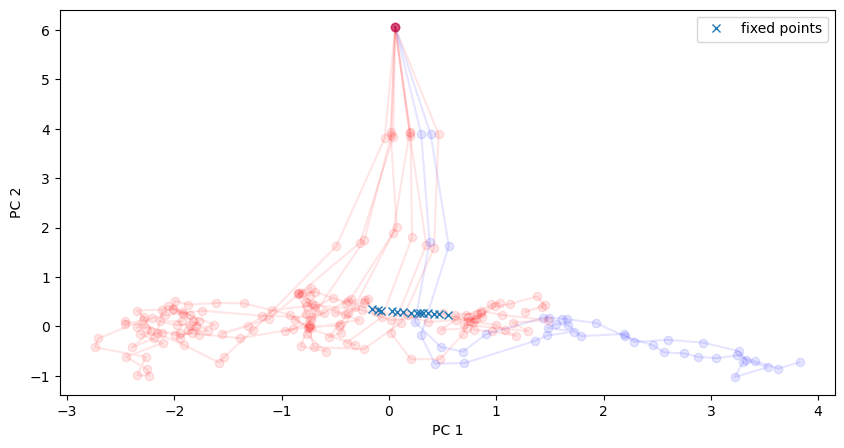

In [16]:
# Plot in the same space as activity
plt.figure(figsize=(10, 5))
for i in range(10):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'
    plt.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color, alpha=0.1)

# Fixed points are shown in cross
fixedpoints_pc = pca.transform(fixed_points)
plt.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x', label='fixed points')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()

## Computing the Jacobian and finding the line attractor

In [17]:
from jax import jacobian

In [18]:
dFdh = jacobian(f_cell)(fixed_points[10])

eigval, eigvec = np.linalg.eig(bm.as_numpy(dFdh))

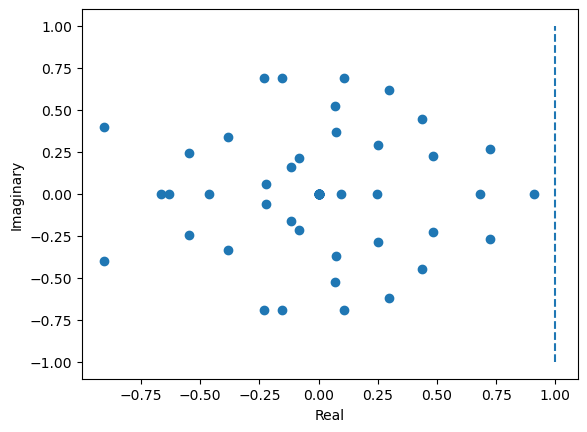

In [19]:
# Plot distribution of eigenvalues in a 2-d real-imaginary plot
plt.figure()
plt.scatter(np.real(eigval), np.imag(eigval))
plt.plot([1, 1], [-1, 1], '--')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()